# Unrolled Motif Analysis

This notebook walks through the **unrolled motif** framework — feedforward-compatible
analogues of classic regulatory motifs (Alon, 2007) — applied to LLM attribution graphs.

Standard triad census treats all directed 3-node subgraphs equally. Unrolled motifs add
**layer-ordering** and **edge-sign** constraints, testing whether transformers implement
computational patterns like mutual inhibition, negative feedback, and coherent/incoherent
feedforward loops across layers.

**Sections:**
1. Setup & imports
2. The unrolled motif catalog
3. Layer structure validation
4. Single graph walkthrough (Dallas circuit)
5. Null model & Z-scores
6. Visualize top motif instances
7. Batch analysis across all graphs
8. Cross-task Z-score heatmap
9. Co-occurrence analysis
10. Comparison with standard triad census
11. Key findings & interpretation

In [1]:
import sys
sys.path.insert(0, "..")

import json
import os
import pickle
from pathlib import Path
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src.graph_loader import load_attribution_graph, graph_summary
from src.unrolled_motifs import (
    build_catalog, CATALOG,
    validate_layer_ordering, layer_stats, layer_gap_distribution,
)
from src.unrolled_census import (
    run_unrolled_census, unrolled_census_counts, unrolled_census_summary,
)
from src.unrolled_null_model import compute_unrolled_zscores
from src.unrolled_visualization import (
    plot_unrolled_spectrum, plot_unrolled_instance,
    plot_cooccurrence_heatmap, plot_cross_task_unrolled_heatmap,
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

fig_dir = Path("../figures")
fig_dir.mkdir(exist_ok=True)

data_dir = Path("../data/raw")
results_dir = Path("../data/results")

# Edge weight threshold — prunes weak edges before VF2 matching.
# VF2 subgraph isomorphism is combinatorially expensive on dense graphs;
# thresholding at 0.9 keeps only high-confidence attribution edges and
# makes the census tractable (~0.3s/iteration vs ~100s without pruning).
WEIGHT_THRESHOLD = 0.9

## 2. The Unrolled Motif Catalog

Eight feedforward-compatible analogues of classic recurrent regulatory motifs.
Each template specifies node count, edge count, sign constraints, and the
classic motif it "unrolls".

In [2]:
catalog = build_catalog()

print(f"{'#':<3s}  {'Name':<30s}  {'Classic Analogue':<30s}  {'Nodes':>5s}  {'Edges':>5s}")
print("-" * 78)
for i, t in enumerate(catalog, 1):
    print(f"{i:<3d}  {t.name:<30s}  {t.classic_analogue:<30s}  {t.num_nodes:>5d}  {t.num_edges:>5d}")

print(f"\nTotal templates: {len(catalog)}")

#    Name                            Classic Analogue                Nodes  Edges
------------------------------------------------------------------------------
1    cross_chain_inhibition          mutual_inhibition                   4      4
2    feedforward_damping             negative_feedback                   3      2
3    feedforward_amplification       positive_feedback                   3      2
4    residual_self_loop_positive     positive_autoregulation             2      1
5    residual_self_loop_negative     negative_autoregulation             2      1
6    coherent_ffl                    coherent_feedforward_loop           3      3
7    incoherent_ffl                  incoherent_feedforward_loop         3      3
8    cross_chain_toggle              bistable_switch                     5      4

Total templates: 8


In [3]:
# Detailed view of each template
for t in catalog:
    print(f"\n{'='*70}")
    print(f"  {t.name}")
    print(f"  Classic analogue: {t.classic_analogue}")
    print(f"  {t.description}")
    print(f"  Nodes: {t.node_ids}")
    print(f"  Roles: {t.roles}")
    print(f"  Edges:")
    for e in t.edges:
        sign_str = "+" if e['sign'] == 1 else "-" if e['sign'] == -1 else "?"
        print(f"    {e['src']} --({sign_str})--> {e['tgt']}")
    print(f"  Layer gap: [{t.min_layer_gap}, {t.max_layer_gap}]")


  cross_chain_inhibition
  Classic analogue: mutual_inhibition
  Two processing chains mutually suppress each other across layers. The feedforward analogue of mutual inhibition — implements competition between alternative interpretations.
  Nodes: ['A_early', 'B_early', 'A_late', 'B_late']
  Roles: {'A_early': 'chain_a_source', 'B_early': 'chain_b_source', 'A_late': 'chain_a_target', 'B_late': 'chain_b_target'}
  Edges:
    A_early --(+)--> A_late
    B_early --(+)--> B_late
    A_early --(-)--> B_late
    B_early --(-)--> A_late
  Layer gap: [1, 5]

  feedforward_damping
  Classic analogue: negative_feedback
  A feature activates an intermediary that then suppresses a downstream instance of the same logical role. Implements self-regulation / gain control.
  Nodes: ['A_early', 'B_mid', 'A_late']
  Roles: {'A_early': 'source', 'B_mid': 'damper', 'A_late': 'target'}
  Edges:
    A_early --(+)--> B_mid
    B_mid --(-)--> A_late
  Layer gap: [1, 5]

  feedforward_amplification
  Classic a

## 3. Layer Structure Validation

Before running the unrolled census, we validate that all attribution graphs
have proper forward layer ordering (all edges go from lower to higher layers).
This is a prerequisite for the layer-aware motif matching.

In [4]:
# Collect all graph paths, grouped by category
categories = sorted([
    d.name for d in data_dir.iterdir()
    if d.is_dir() and not d.name.startswith('.') and d.name not in ('cross_model', 'gemma-2-2b', 'qwen3-4b')
])

all_graph_paths: dict[str, list[Path]] = {}
for cat in categories:
    cat_dir = data_dir / cat
    paths = sorted(cat_dir.glob("*.json"))
    if paths:
        all_graph_paths[cat] = paths

total_graphs = sum(len(v) for v in all_graph_paths.values())
print(f"Found {total_graphs} graphs across {len(all_graph_paths)} categories:")
for cat, paths in sorted(all_graph_paths.items()):
    print(f"  {cat}: {len(paths)} graphs")

Found 99 graphs across 9 categories:
  arithmetic: 14 graphs
  code: 4 graphs
  creative: 3 graphs
  factual_recall: 27 graphs
  multihop: 10 graphs
  multilingual: 6 graphs
  reasoning: 14 graphs
  safety: 11 graphs
  uncategorized: 10 graphs


In [5]:
# Validate layer ordering and collect statistics
validation_results = []
all_gap_counts = defaultdict(int)
all_layer_counts = []
all_nodes_per_layer = []

n_valid = 0
n_invalid = 0

for cat, paths in sorted(all_graph_paths.items()):
    for p in paths:
        g = load_attribution_graph(p)
        is_valid, backward = validate_layer_ordering(g)
        stats = layer_stats(g)

        if is_valid:
            n_valid += 1
        else:
            n_invalid += 1
            print(f"  WARNING: {cat}/{p.stem} has {len(backward)} backward edges")

        validation_results.append({
            'category': cat,
            'name': p.stem,
            'n_nodes': g.vcount(),
            'n_edges': g.ecount(),
            'n_layers': stats['n_layers'],
            'all_forward': stats['all_forward'],
            'n_backward': stats['n_backward_edges'],
        })

        all_layer_counts.append(stats['n_layers'])
        for layer, count in stats['nodes_per_layer'].items():
            all_nodes_per_layer.append(count)
        for gap, count in stats['gap_distribution'].items():
            all_gap_counts[gap] += count

print(f"\nValidation: {n_valid}/{n_valid + n_invalid} graphs have all-forward edges")
if n_invalid > 0:
    print(f"  {n_invalid} graph(s) have backward edges — these will have reduced matching")


Validation: 99/99 graphs have all-forward edges


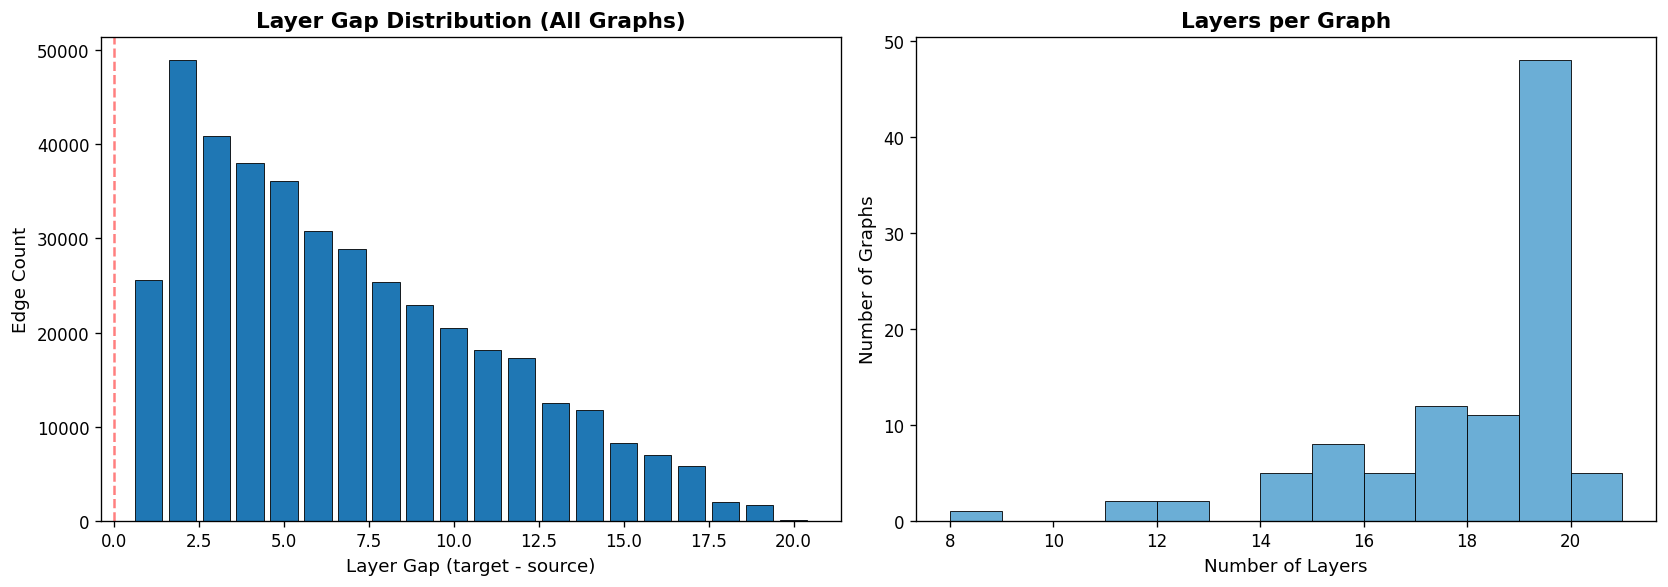

Layer count range: 8 - 20 (mean 17.6)
Nodes per layer: mean 7.8, median 5, max 138


In [6]:
# Layer gap distribution across all graphs
gaps = sorted(all_gap_counts.keys())
counts = [all_gap_counts[g] for g in gaps]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: layer gap histogram
colors = ['#d62728' if g <= 0 else '#1f77b4' for g in gaps]
axes[0].bar(gaps, counts, color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Layer Gap (target - source)', fontsize=11)
axes[0].set_ylabel('Edge Count', fontsize=11)
axes[0].set_title('Layer Gap Distribution (All Graphs)', fontsize=13, fontweight='bold')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Right: layers per graph histogram
axes[1].hist(all_layer_counts, bins=range(min(all_layer_counts), max(all_layer_counts) + 2),
             color='#6baed6', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Number of Layers', fontsize=11)
axes[1].set_ylabel('Number of Graphs', fontsize=11)
axes[1].set_title('Layers per Graph', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Layer count range: {min(all_layer_counts)} - {max(all_layer_counts)} "
      f"(mean {np.mean(all_layer_counts):.1f})")
print(f"Nodes per layer: mean {np.mean(all_nodes_per_layer):.1f}, "
      f"median {np.median(all_nodes_per_layer):.0f}, "
      f"max {max(all_nodes_per_layer)}")

## 4. Single Graph Walkthrough — Dallas Circuit

We start with a detailed walkthrough on the multi-hop Dallas circuit
("The capital of the state containing Dallas is") to understand the
unrolled census in detail.

In [7]:
# Load the Dallas multi-hop graph
dallas_path = data_dir / "multihop" / "capital-state-dallas.json"
if not dallas_path.exists():
    # Fallback to first available multihop graph
    dallas_path = sorted((data_dir / "multihop").glob("*.json"))[0]
    print(f"Dallas graph not found, using: {dallas_path.name}")

g_dallas = load_attribution_graph(dallas_path)
summ = graph_summary(g_dallas)
print(f"Graph: {dallas_path.stem}")
print(f"  Nodes: {summ['n_nodes']}, Edges: {summ['n_edges']}")
print(f"  Density: {summ['density']:.4f}")
print(f"  Prompt: {summ.get('prompt', 'N/A')}")

stats = layer_stats(g_dallas)
is_valid, _ = validate_layer_ordering(g_dallas)
print(f"  Layers: {stats['n_layers']}, All forward: {is_valid}")
print(f"  Nodes per layer: {dict(sorted(stats['nodes_per_layer'].items()))}")

Graph: capital-state-dallas
  Nodes: 83, Edges: 1719
  Density: 0.2526
  Prompt: Fact: the capital of the state containing Dallas is 
  Layers: 19, All forward: True
  Nodes per layer: {-1: 11, 1: 12, 2: 6, 3: 9, 4: 4, 5: 3, 6: 4, 7: 5, 8: 1, 9: 1, 10: 4, 11: 5, 12: 2, 13: 2, 14: 3, 15: 5, 16: 4, 17: 1, 19: 1}


In [8]:
# Run unrolled census
census = run_unrolled_census(g_dallas, weight_threshold=WEIGHT_THRESHOLD)
counts = unrolled_census_counts(census)
summary_dict = unrolled_census_summary(census)

print(f"Weight threshold: {WEIGHT_THRESHOLD}")
print(f"\n{'Motif':<30s}  {'Count':>6s}  {'Mean W':>8s}  {'Max W':>8s}  {'Mean Gap':>8s}")
print("-" * 68)
for name in counts:
    s = summary_dict[name]
    print(f"{name:<30s}  {s['count']:>6d}  {s['mean_weight']:>8.2f}  "
          f"{s['max_weight']:>8.2f}  {s['mean_layer_gap']:>8.2f}")

total = sum(counts.values())
print(f"\nTotal instances: {total}")
print(f"Non-zero motif types: {sum(1 for c in counts.values() if c > 0)}/{len(counts)}")

Weight threshold: 0.9

Motif                            Count    Mean W     Max W  Mean Gap
--------------------------------------------------------------------
cross_chain_inhibition               0      0.00      0.00      0.00
feedforward_damping                  6      5.84      9.51      2.17
feedforward_amplification           29     11.58     45.30      2.62
residual_self_loop_positive         60      5.25     88.59      2.27
residual_self_loop_negative          3      1.85      2.76      1.33
coherent_ffl                        11     14.67     46.35      2.73
incoherent_ffl                       0      0.00      0.00      0.00
cross_chain_toggle                   1     15.66     15.66      2.00

Total instances: 110
Non-zero motif types: 6/8


In [9]:
# Show top instances for motifs with non-zero counts
for name, instances in census.items():
    if not instances:
        continue
    top = instances[0]
    print(f"\n--- {name} (top instance, weight={top.total_weight:.2f}) ---")
    print(f"  Nodes: {top.node_indices}")
    print(f"  Layers: {top.layers}")
    print(f"  Edge signs: {top.edge_signs}")
    print(f"  Edge weights: {[f'{w:.2f}' for w in top.edge_weights]}")
    for node_idx, role in top.node_roles.items():
        clerp = g_dallas.vs[node_idx]['clerp'] if 'clerp' in g_dallas.vs.attributes() else 'N/A'
        layer = g_dallas.vs[node_idx]['layer']
        print(f"  {role:20s}: node {node_idx}, layer {layer}, {clerp}")


--- feedforward_damping (top instance, weight=9.51) ---
  Nodes: (54, 58, 39)
  Layers: [14, 15, 16]
  Edge signs: ['excitatory', 'inhibitory']
  Edge weights: ['6.75', '-2.76']
  source              : node 54, layer 14, say a capital
  damper              : node 58, layer 15, say a capital
  target              : node 39, layer 16, say a capital

--- feedforward_amplification (top instance, weight=45.30) ---
  Nodes: (18, 17, 16)
  Layers: [-1, 1, 2]
  Edge signs: ['excitatory', 'excitatory']
  Edge weights: ['42.21', '3.09']
  source              : node 18, layer -1, 
  amplifier           : node 17, layer 1, state
  target              : node 16, layer 2, state

--- residual_self_loop_positive (top instance, weight=88.59) ---
  Nodes: (3, 1)
  Layers: [-1, 1]
  Edge signs: ['excitatory']
  Edge weights: ['88.59']
  source              : node 3, layer -1, 
  target              : node 1, layer 1, uppercase

--- residual_self_loop_negative (top instance, weight=2.76) ---
  Nodes: (58

## 5. Null Model & Z-Scores

Compute Z-scores against a **layer-preserving** null model.
The null model rewires edges while maintaining:
1. Forward layer ordering (all edges go from lower to higher layers)
2. Degree distribution
3. Edge sign distribution

In [10]:
# Compute Z-scores and SP with 100 null model rewirings
null_result = compute_unrolled_zscores(
    g_dallas,
    n_random=1000,
    weight_threshold=WEIGHT_THRESHOLD,
    show_progress=True,
    seed=42,
)

print(f"\nWeight threshold: {WEIGHT_THRESHOLD}")
print(f"Acceptance rate: {null_result.acceptance_rate:.3f}")
print(f"\n{'Motif':<30s}  {'Real':>6s}  {'Mean Null':>9s}  {'Std Null':>8s}  {'Z-score':>8s}  {'SP':>8s}")
print("-" * 78)
for name in null_result.z_scores:
    print(f"{name:<30s}  {null_result.real_counts[name]:>6d}  "
          f"{null_result.mean_null[name]:>9.1f}  "
          f"{null_result.std_null[name]:>8.1f}  "
          f"{null_result.z_scores[name]:>+8.2f}  "
          f"{null_result.sp[name]:>+8.3f}")

Unrolled null model: 100%|██████████| 1000/1000 [05:00<00:00,  3.33graph/s]


Weight threshold: 0.9
Acceptance rate: 0.048

Motif                             Real  Mean Null  Std Null   Z-score        SP
------------------------------------------------------------------------------
cross_chain_inhibition               0        0.0       0.0     +0.00    +0.000
feedforward_damping                  6        5.1       1.2     +0.81    +0.124
feedforward_amplification           29       23.9       4.9     +1.03    +0.159
residual_self_loop_positive         60       50.4       2.6     +3.69    +0.568
residual_self_loop_negative          3        3.0       0.0     +0.00    +0.000
coherent_ffl                        11        4.6       1.2     +5.17    +0.797
incoherent_ffl                       0        0.0       0.0     +0.00    +0.000
cross_chain_toggle                   1        1.1       0.3     -0.26    -0.040


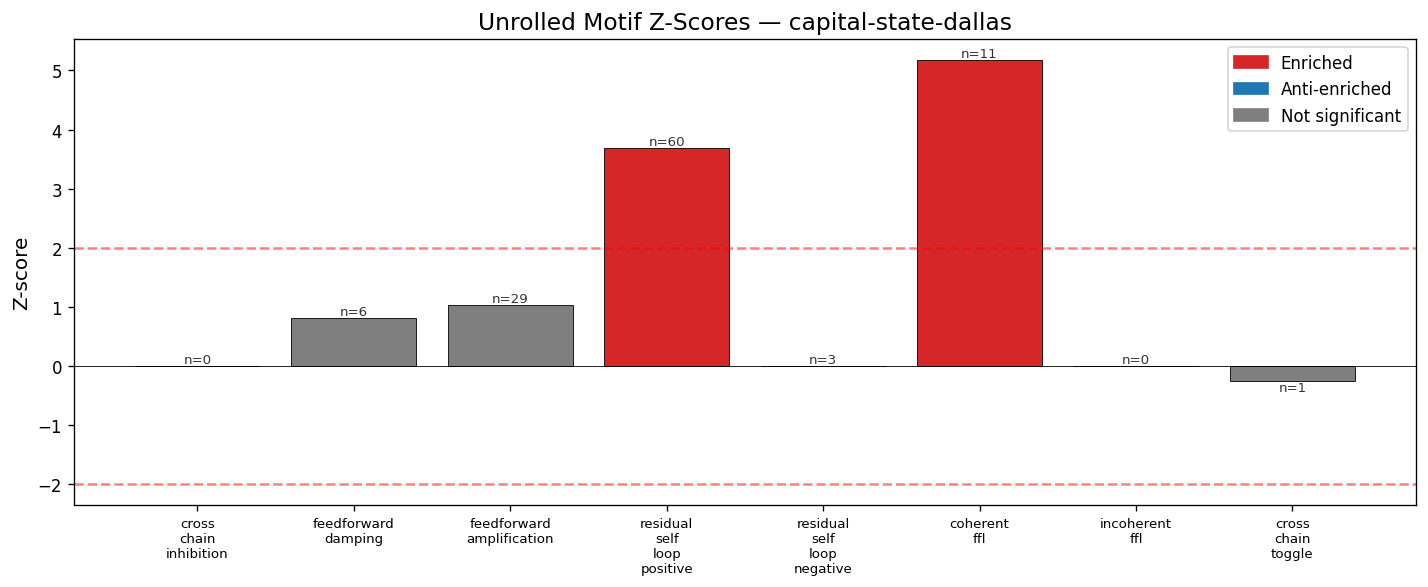

In [11]:
# Plot Z-score spectrum
fig = plot_unrolled_spectrum(
    null_result,
    title=f"Unrolled Motif Z-Scores — {dallas_path.stem}",
)
plt.show()

## 6. Visualize Top Motif Instances

For each motif type with instances found, visualize the highest-weight
instance overlaid on the attribution graph.


Feedforward Damping — top instance (weight=9.51)
  source              : layer 14, say a capital
  damper              : layer 15, say a capital
  target              : layer 16, say a capital


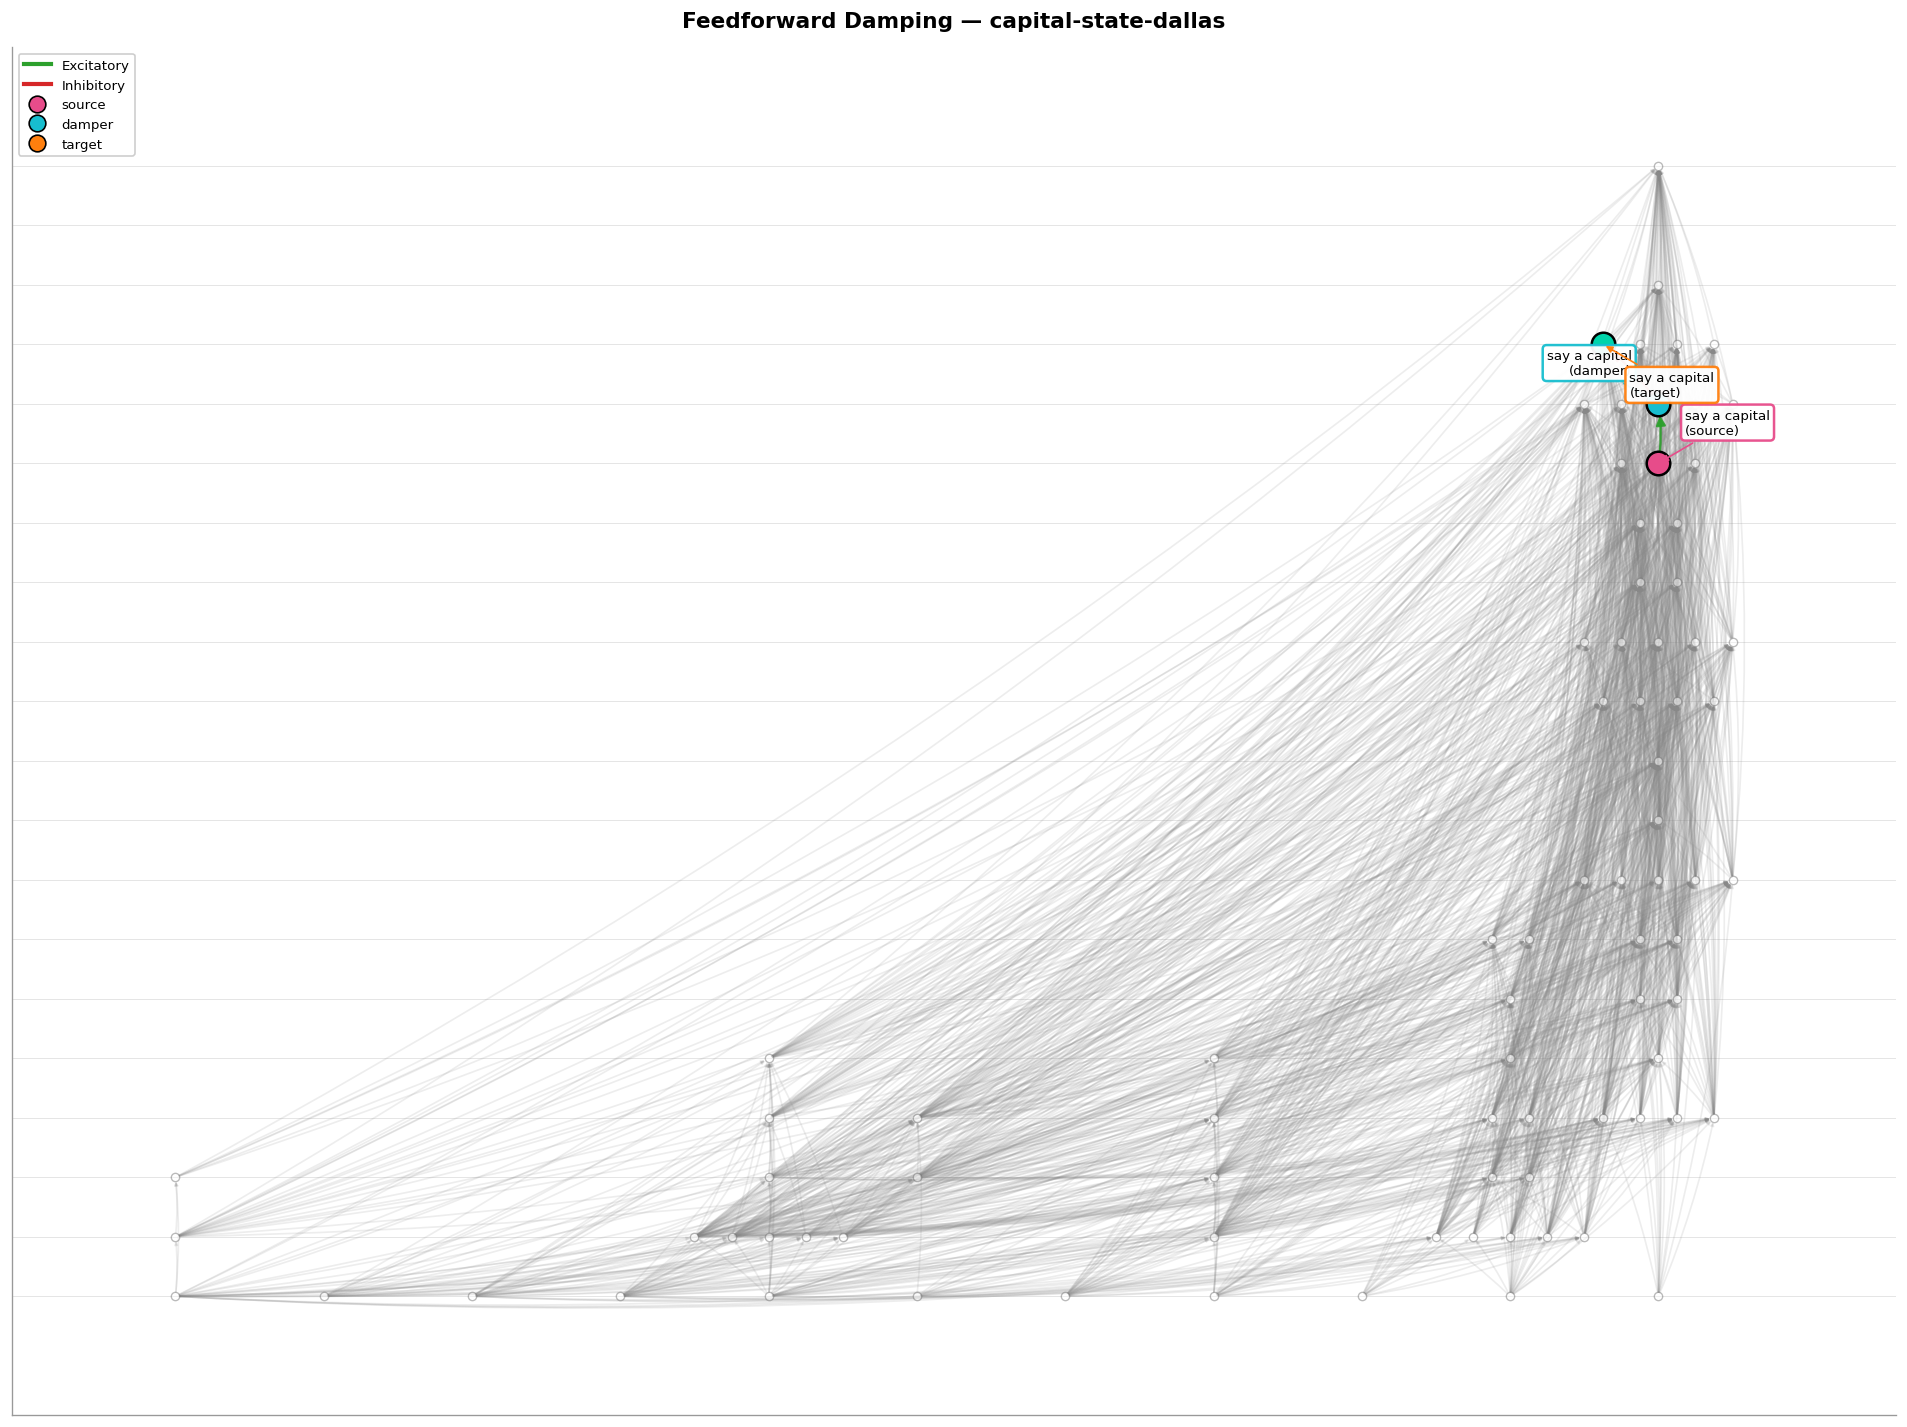


Feedforward Amplification — top instance (weight=45.30)
  source              : layer -1, 
  amplifier           : layer 1, state
  target              : layer 2, state


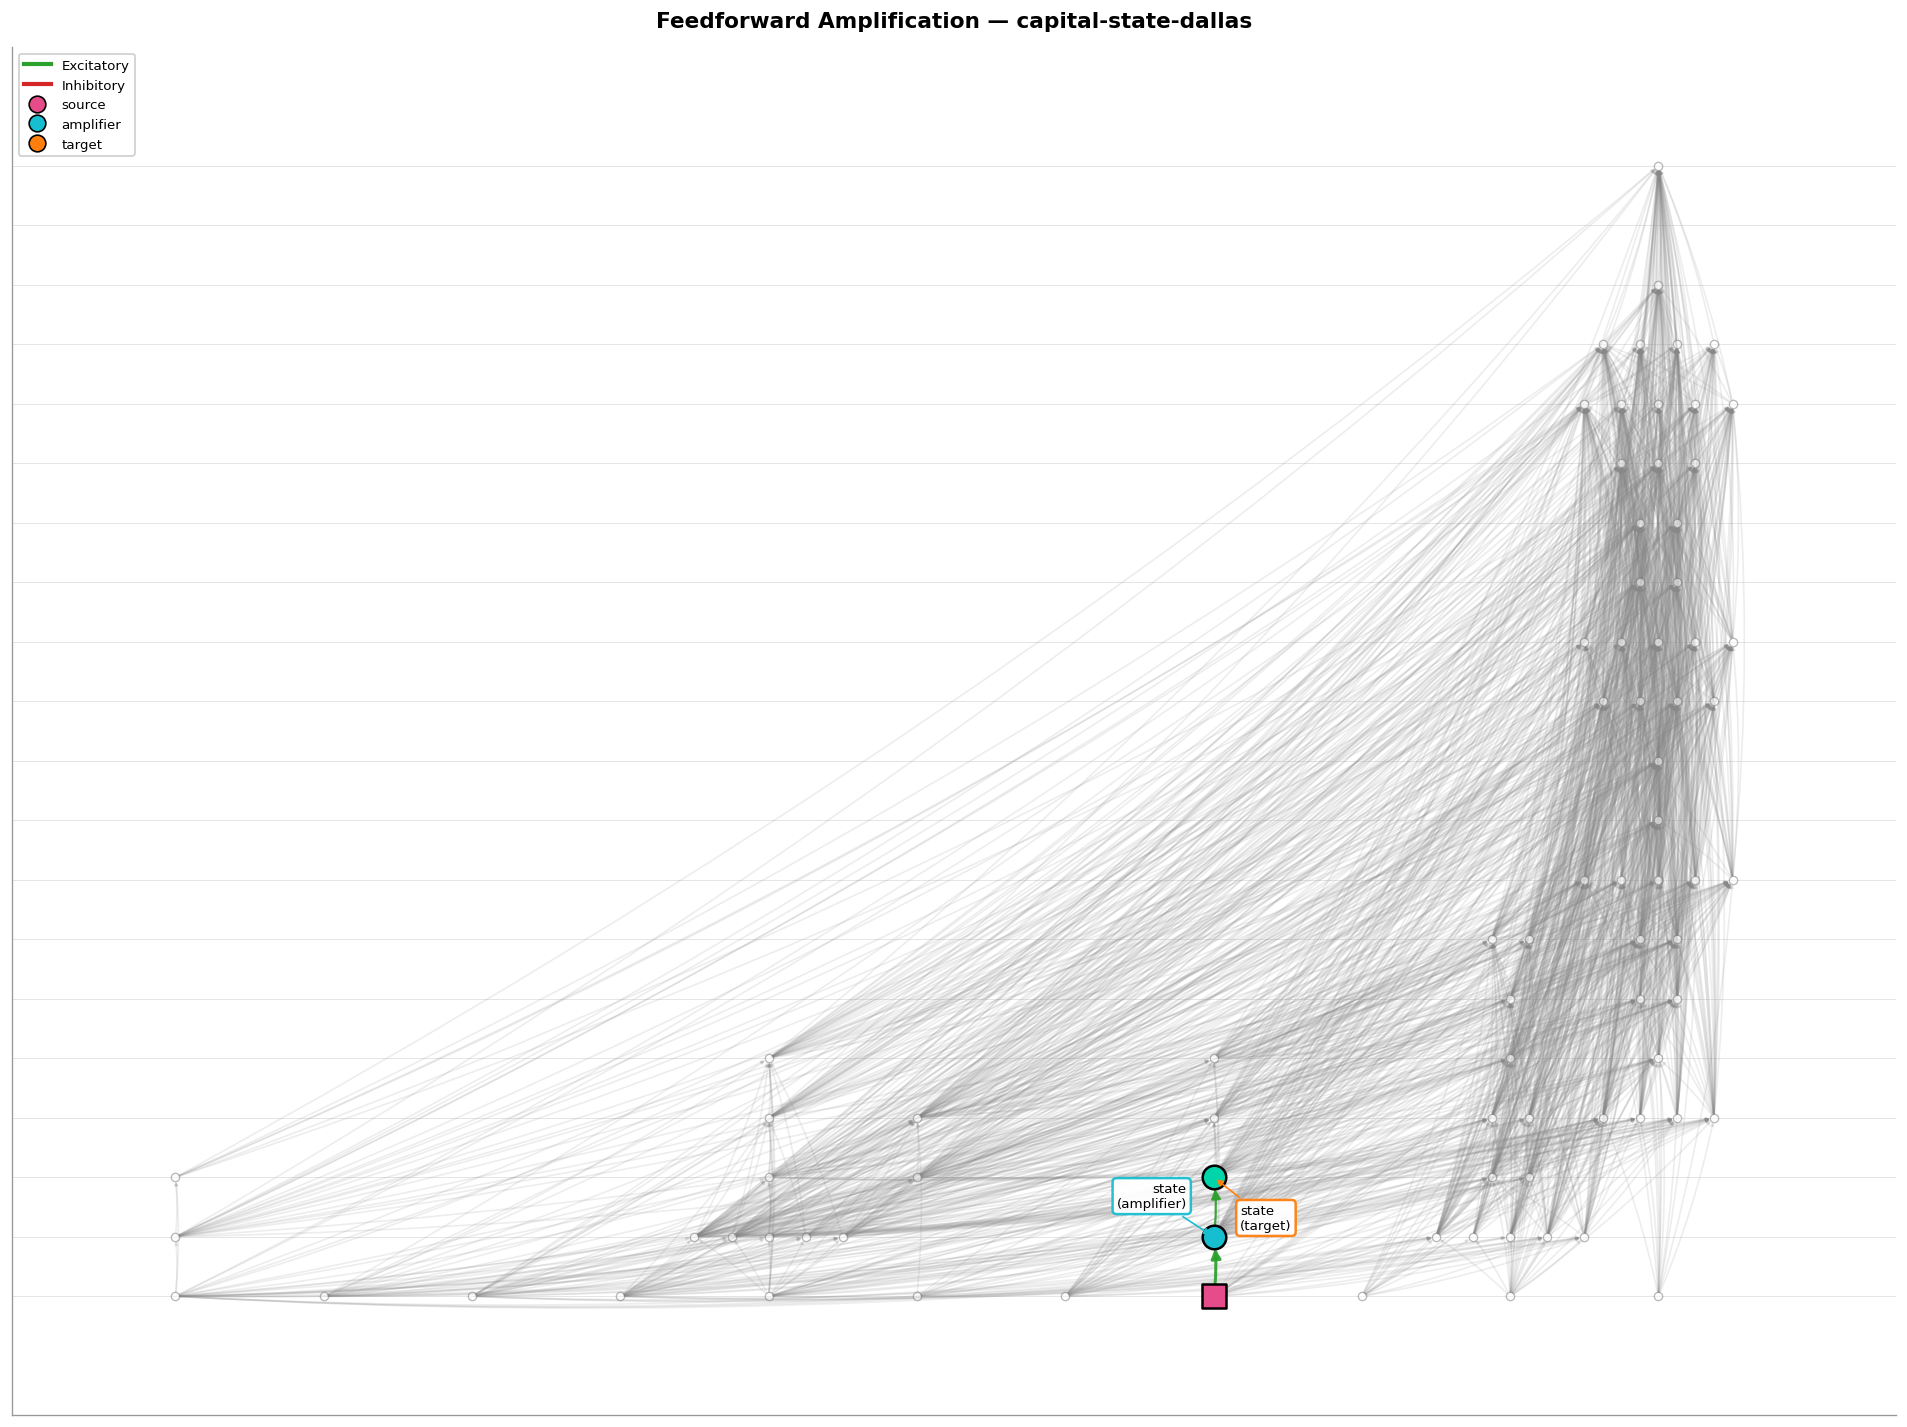


Residual Self Loop Positive — top instance (weight=88.59)
  source              : layer -1, 
  target              : layer 1, uppercase


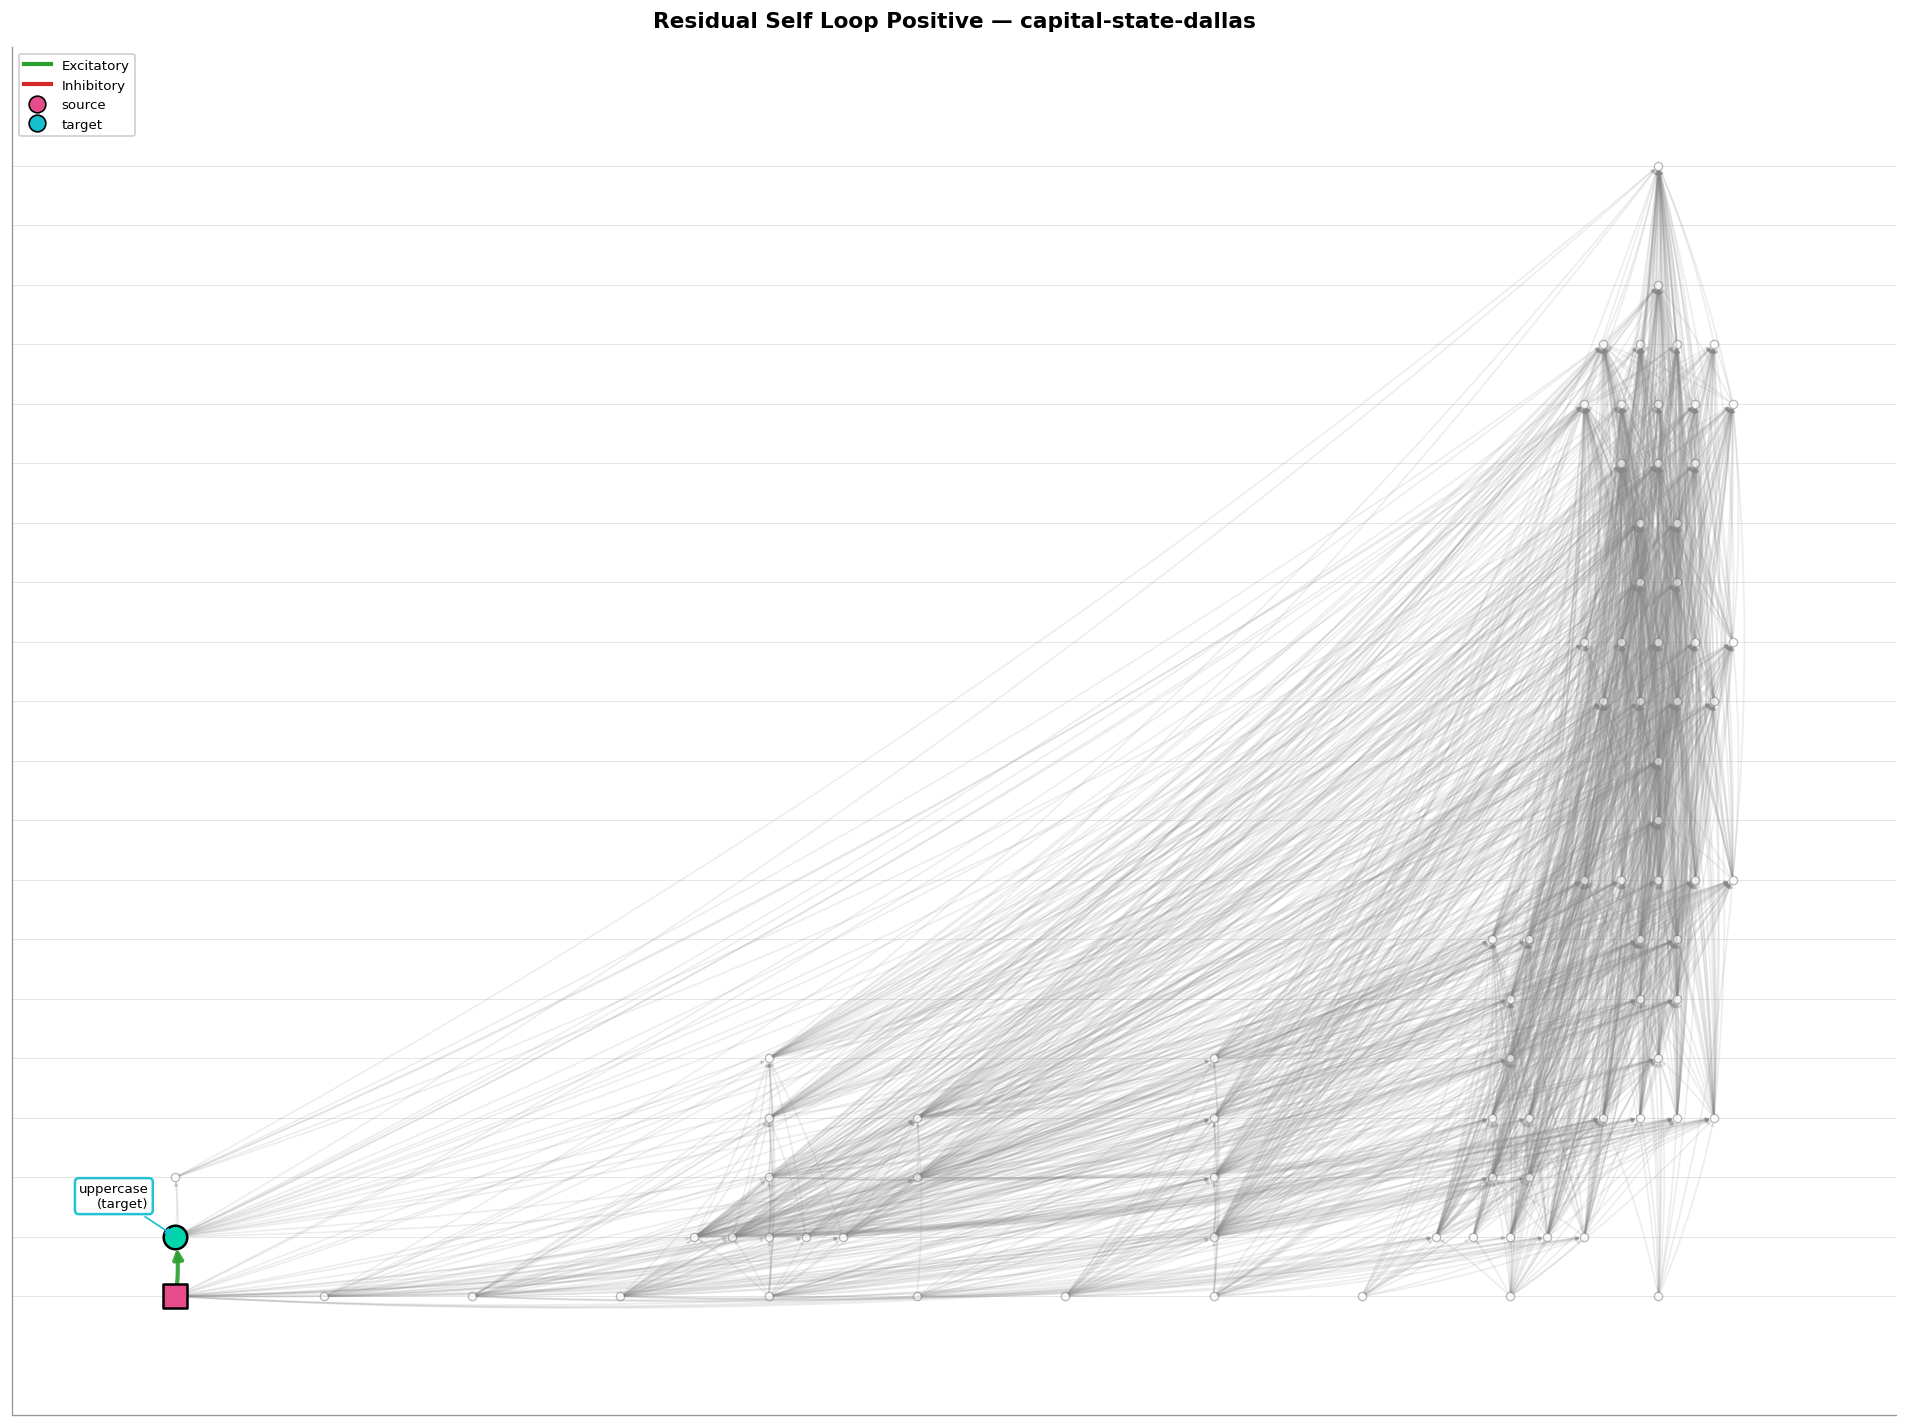


Residual Self Loop Negative — top instance (weight=2.76)
  source              : layer 15, say a capital
  target              : layer 16, say a capital


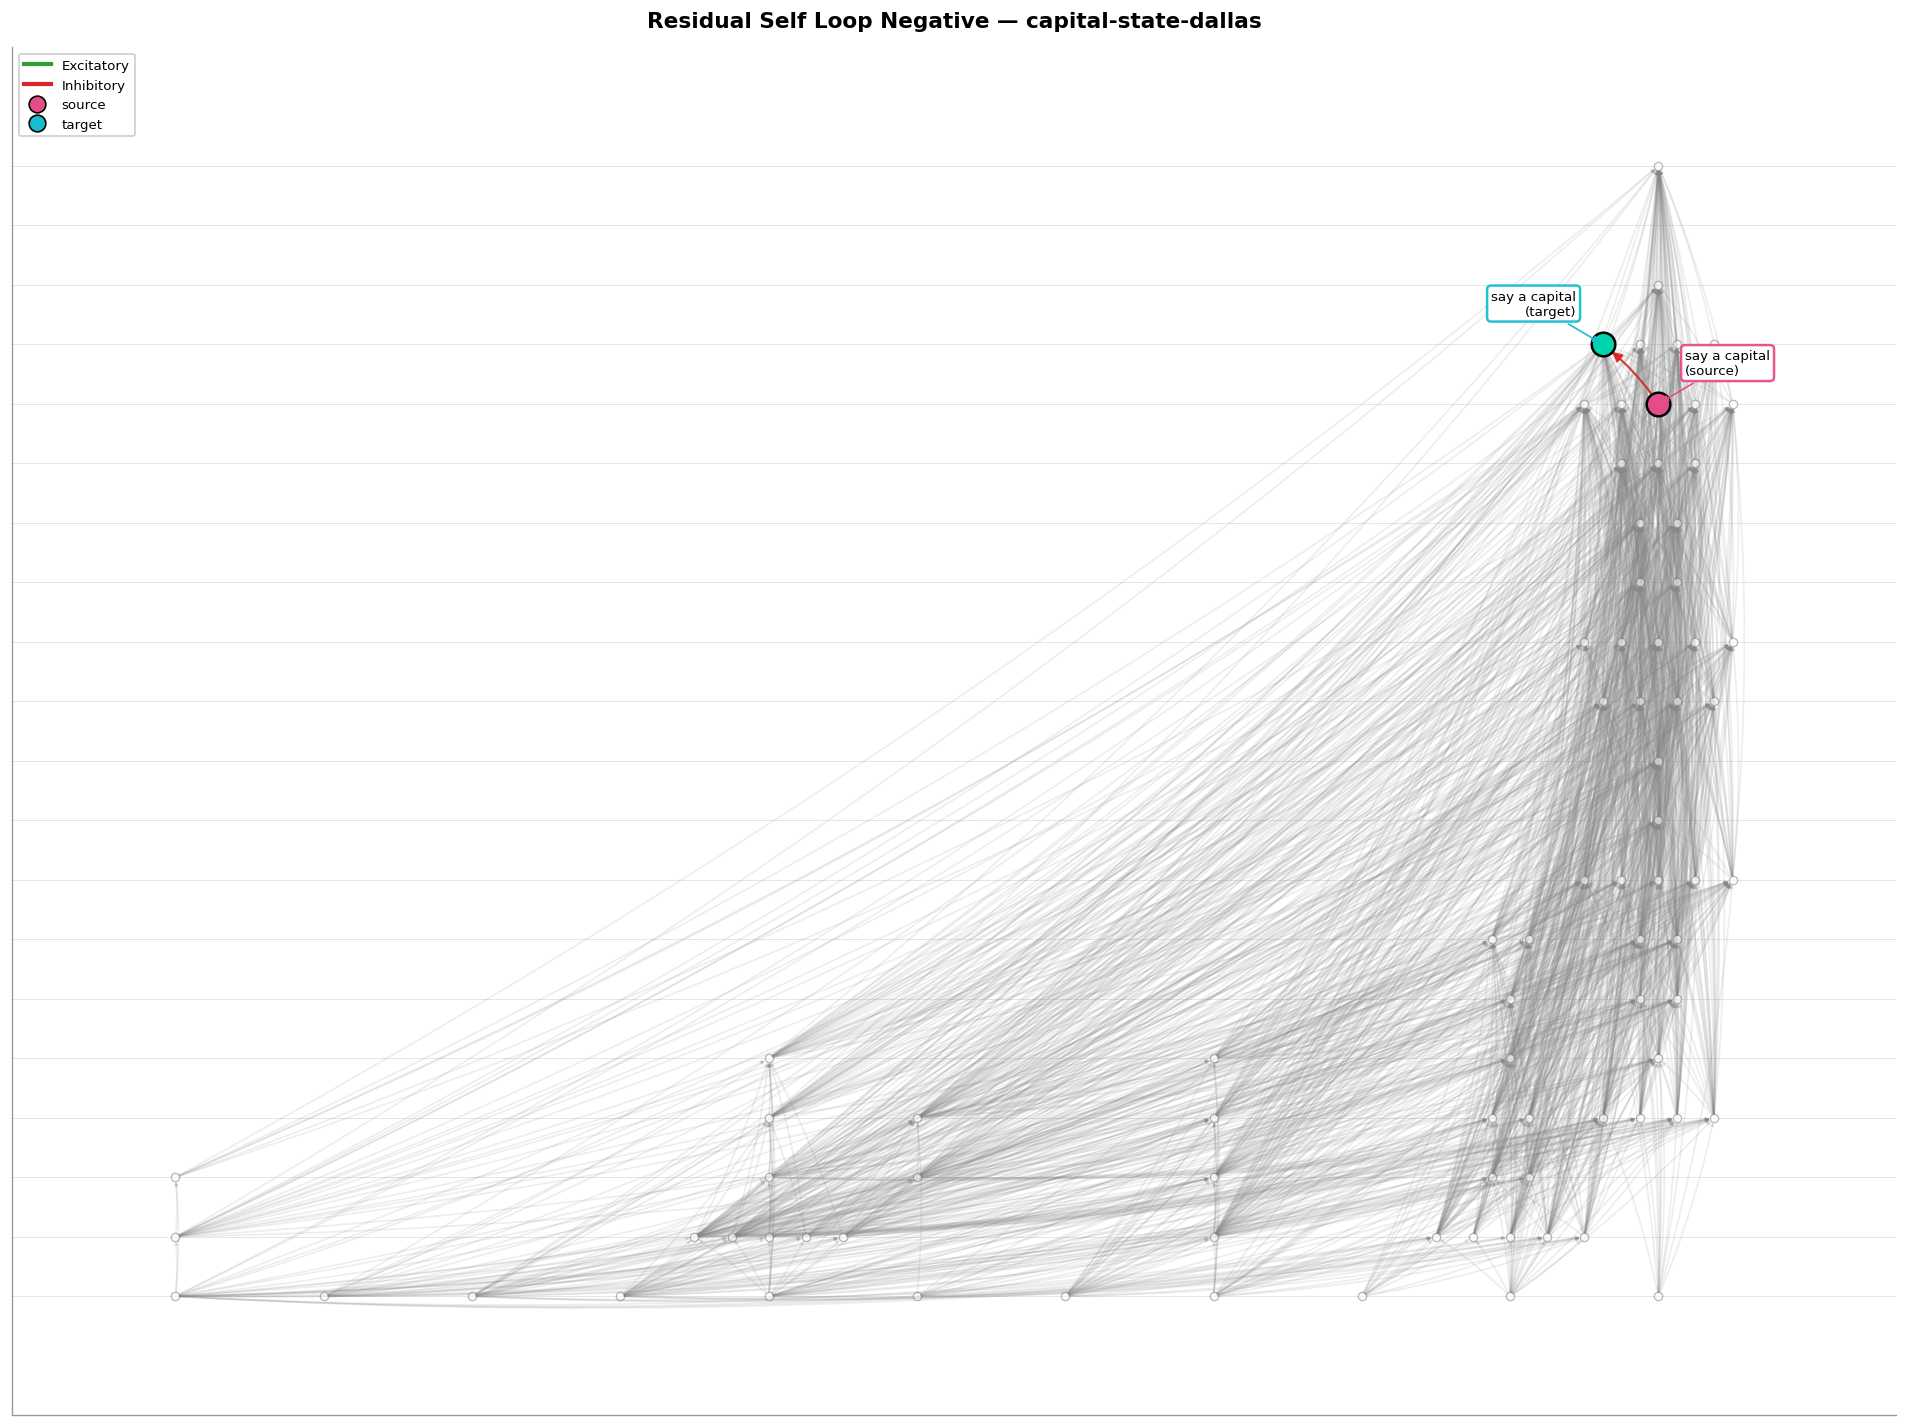


Coherent Ffl — top instance (weight=46.35)
  regulator           : layer -1, 
  mediator            : layer 1, state
  target              : layer 2, state


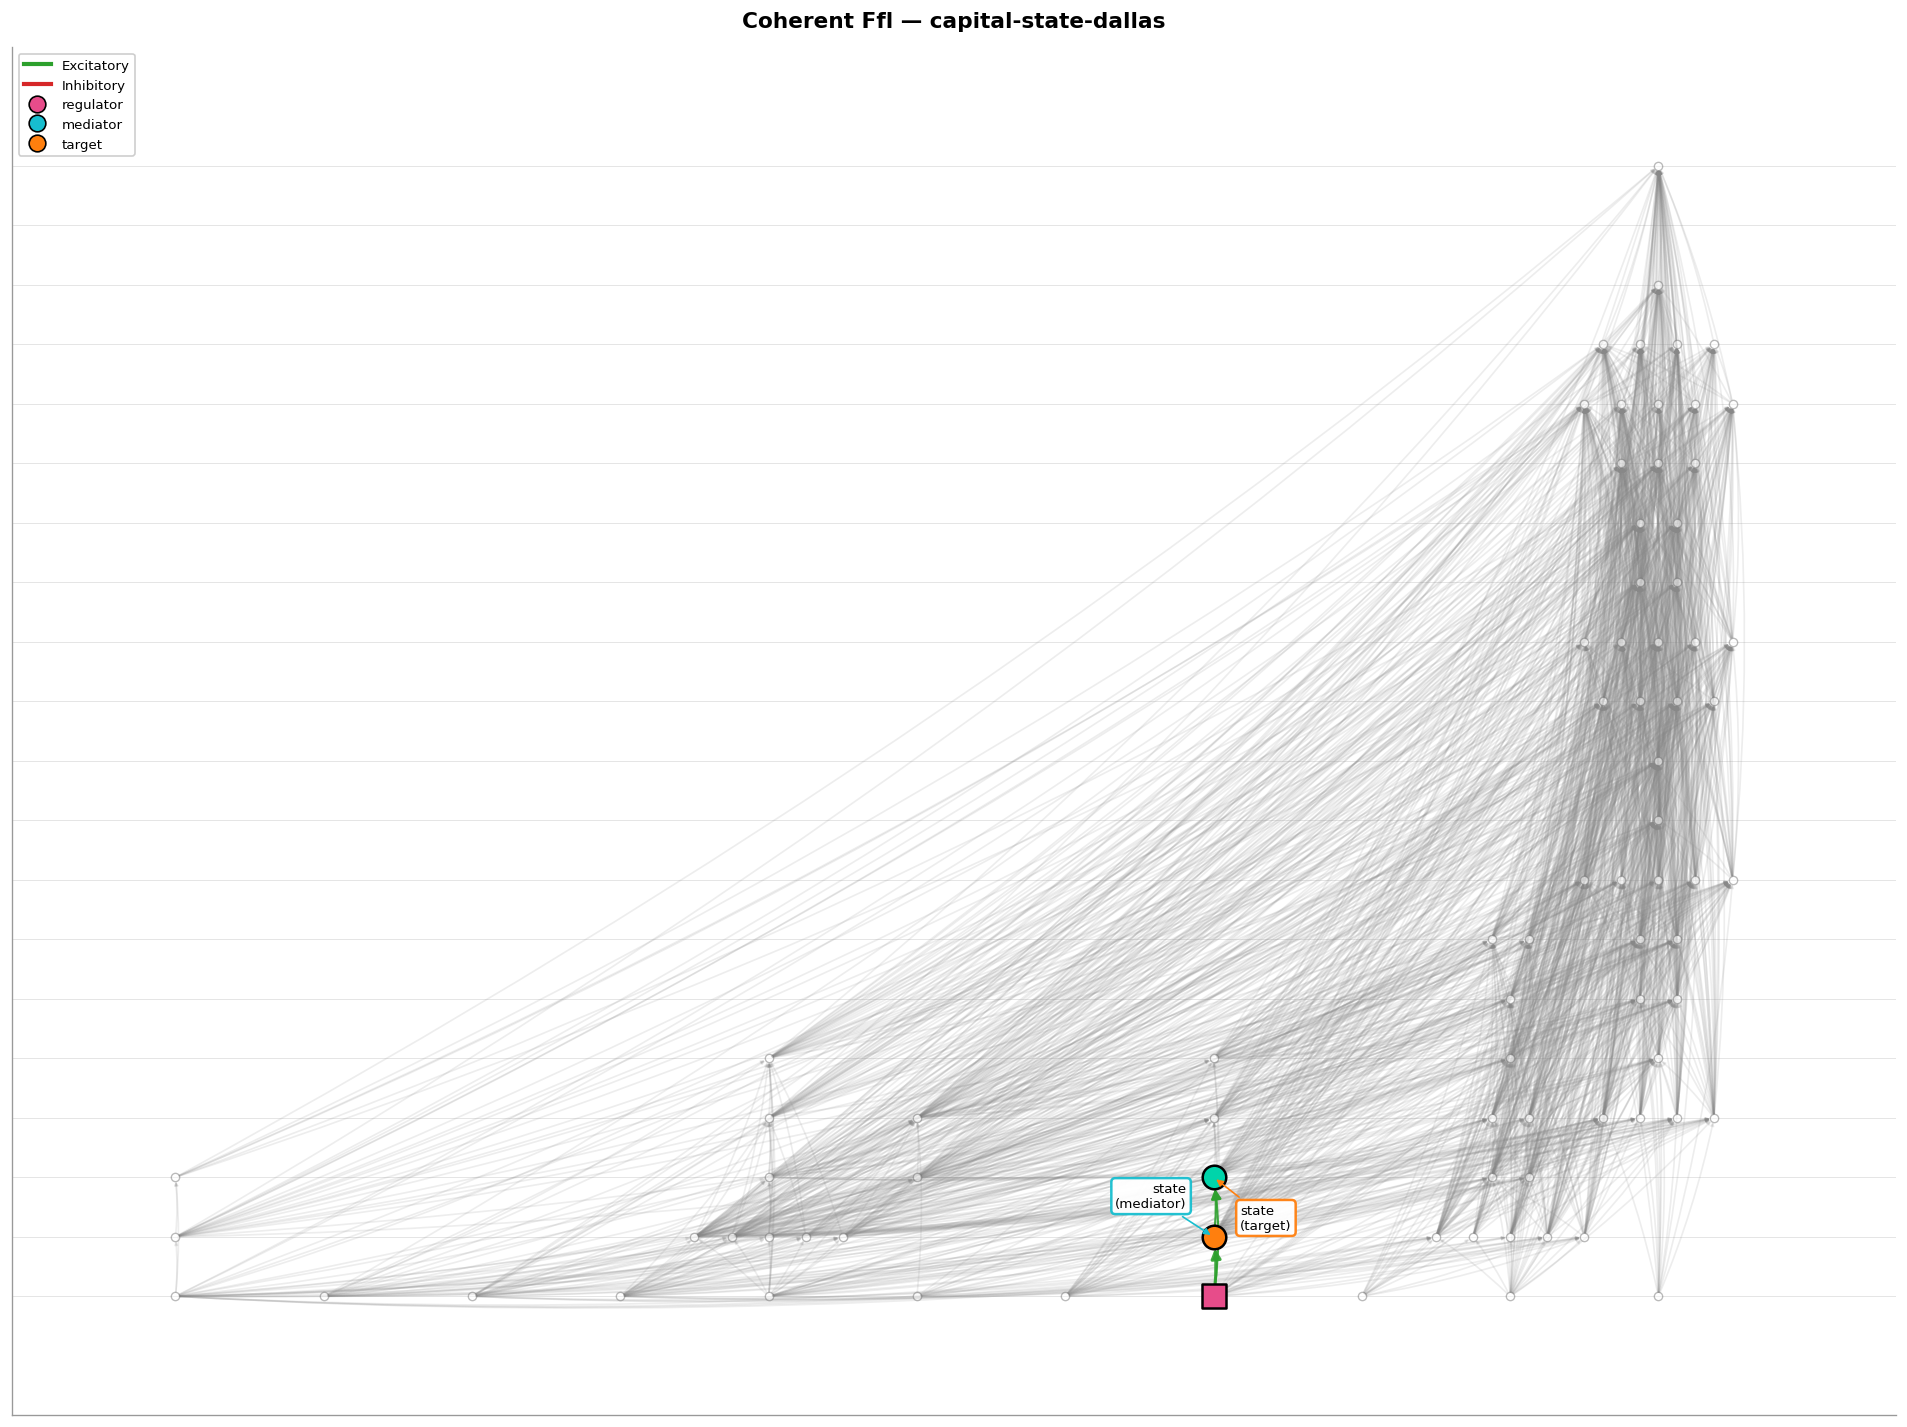


Cross Chain Toggle — top instance (weight=15.66)
  bias                : layer 14, say a capital
  chain_a_mid         : layer 15, say a capital
  chain_b_mid         : layer 15, say a capital
  chain_a_target      : layer 17, say a place in Texas
  chain_b_target      : layer 16, say a capital


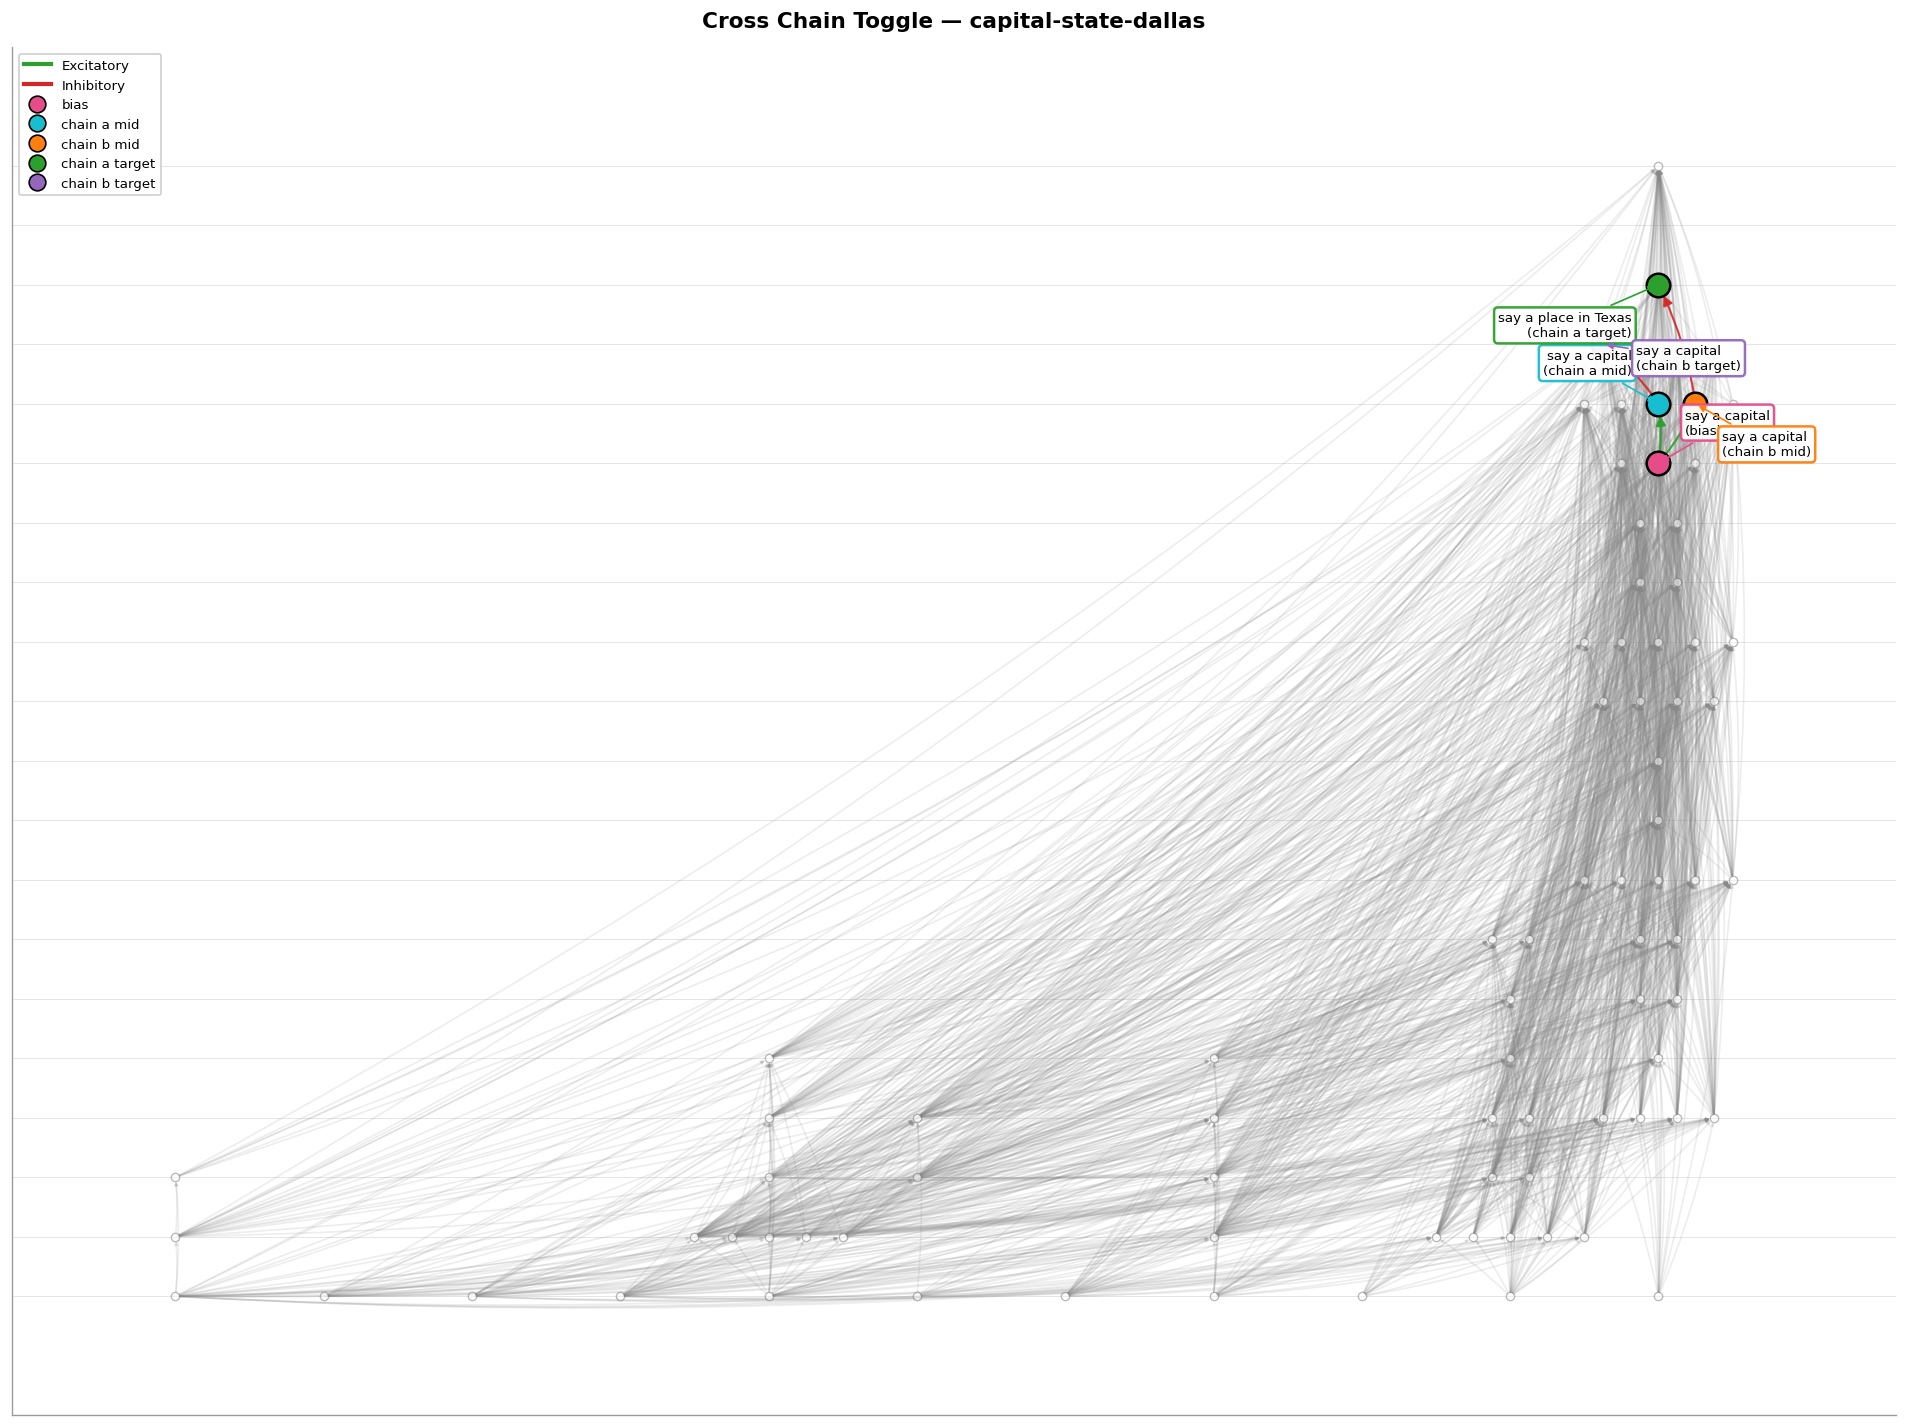

In [12]:
# Visualize top instance for each motif with matches
for name, instances in census.items():
    if not instances:
        continue

    top = instances[0]
    template = CATALOG[name]
    pretty = name.replace('_', ' ').title()

    print(f"\n{'='*60}")
    print(f"{pretty} — top instance (weight={top.total_weight:.2f})")
    print(f"{'='*60}")

    for node_idx, role in top.node_roles.items():
        clerp = g_dallas.vs[node_idx]['clerp'] if 'clerp' in g_dallas.vs.attributes() else 'N/A'
        layer = g_dallas.vs[node_idx]['layer']
        print(f"  {role:20s}: layer {layer}, {clerp}")

    fig = plot_unrolled_instance(
        g_dallas, top, template=template,
        title=f"{pretty} — {dallas_path.stem}",
        figsize=(16, 12),
    )
    plt.show()

## 7. Batch Analysis Across All Graphs

Run the unrolled census + null model on all graphs. We use `n_random=50`
for speed and `weight_threshold=0.9` to prune weak edges before VF2
matching (otherwise the combinatorial search is too slow on dense graphs).

In [ ]:
# Batch analysis: census + null model per graph
N_RANDOM = 50

batch_results: dict[str, list[dict]] = defaultdict(list)

total = sum(len(v) for v in all_graph_paths.values())
pbar = tqdm(total=total, desc="Batch unrolled analysis")

for cat in sorted(all_graph_paths):
    for p in all_graph_paths[cat]:
        pbar.set_postfix_str(f"{cat}/{p.stem}")
        try:
            g = load_attribution_graph(p)

            # Run census
            census_result = run_unrolled_census(g, weight_threshold=WEIGHT_THRESHOLD)
            cnt = unrolled_census_counts(census_result)

            # Run null model
            null_res = compute_unrolled_zscores(
                g, n_random=N_RANDOM,
                weight_threshold=WEIGHT_THRESHOLD,
                show_progress=False,
                seed=42,
            )

            batch_results[cat].append({
                'name': p.stem,
                'path': str(p),
                'n_nodes': g.vcount(),
                'n_edges': g.ecount(),
                'counts': cnt,
                'z_scores': null_res.z_scores,
                'sp': null_res.sp,
                'acceptance_rate': null_res.acceptance_rate,
                'census': census_result,
            })
        except Exception as e:
            print(f"  ERROR on {cat}/{p.stem}: {e}")

        pbar.update(1)

pbar.close()

print(f"\nCompleted batch analysis (weight_threshold={WEIGHT_THRESHOLD}):")
for cat in sorted(batch_results):
    print(f"  {cat}: {len(batch_results[cat])} graphs")

Batch unrolled analysis:   0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
# Summary: mean counts and Z-scores per category
motif_names = list(CATALOG.keys())

print(f"\n{'Category':<18s}  {'N':>3s}  {'Acc.Rate':>8s}  ", end="")
for m in motif_names:
    short = m[:12]
    print(f"{short:>13s}", end="")
print()
print("-" * (30 + 13 * len(motif_names)))

for cat in sorted(batch_results):
    results_list = batch_results[cat]
    n = len(results_list)
    acc = np.mean([r['acceptance_rate'] for r in results_list])
    print(f"{cat:<18s}  {n:>3d}  {acc:>8.3f}  ", end="")
    for m in motif_names:
        mean_z = np.mean([r['z_scores'].get(m, 0) for r in results_list])
        print(f"{mean_z:>+13.2f}", end="")
    print()


Category              N  Acc.Rate   cross_chain_ feedforward_ feedforward_ residual_sel residual_sel coherent_ffl incoherent_f cross_chain_
--------------------------------------------------------------------------------------------------------------------------------------
arithmetic           14     0.035          +0.44        -0.25        -0.00        +1.71        -0.10        +2.50        +0.53        -0.18
code                  4     0.049          +0.00        +0.03        +0.40        +3.17        -0.28        +7.39        -0.04        -0.33
creative              3     0.078          +2.68        +1.29        +5.86        +5.85        +0.42       +19.36        -0.28        +0.19
factual_recall       27     0.070          -0.03        -0.04        +0.20        +1.91        -0.23        +6.00        -0.15        +0.06
multihop             10     0.041          +0.00        -0.28        +0.43        +0.90        -0.57        +3.35        +0.00        +0.00
multilingual          6 

## 8. Cross-Task Z-Score Heatmap

Aggregate mean Z-scores by task category and visualize as a heatmap.

In [ ]:
# Build task-level Z-scores and SP dicts for heatmaps
task_zscores: dict[str, dict[str, float]] = {}
task_sp: dict[str, dict[str, float]] = {}

for cat in sorted(batch_results):
    results_list = batch_results[cat]
    if not results_list:
        continue
    mean_z: dict[str, float] = {}
    mean_sp: dict[str, float] = {}
    for m in motif_names:
        z_vals = [r['z_scores'].get(m, 0.0) for r in results_list]
        sp_vals = [r['sp'].get(m, 0.0) for r in results_list]
        mean_z[m] = float(np.mean(z_vals))
        mean_sp[m] = float(np.mean(sp_vals))
    task_zscores[cat] = mean_z
    task_sp[cat] = mean_sp

# Z-score heatmap
fig = plot_cross_task_unrolled_heatmap(
    task_zscores,
    title="Unrolled Motif Z-Scores by Task Category",
    cbar_label="Mean Z-score",
    figsize=(14, 6),
)
plt.show()

# SP heatmap — normalized, comparable across graph sizes
fig = plot_cross_task_unrolled_heatmap(
    task_sp,
    title="Unrolled Motif Significance Profiles by Task Category",
    cbar_label="Mean SP",
    figsize=(14, 6),
)
plt.show()

In [ ]:
# Cross-task variation in SP (graph-size-normalized)
print("Cross-task variation in SP (std of mean SP across categories):")
print(f"{'Motif':<30s}  {'Std SP':>8s}  {'Min SP':>8s}  {'Max SP':>8s}  {'Range':>8s}")
print("-" * 60)

variation = []
for m in motif_names:
    vals = [task_sp[cat][m] for cat in task_sp]
    std = np.std(vals)
    variation.append((m, std, min(vals), max(vals)))

variation.sort(key=lambda x: x[1], reverse=True)
for m, std, mn, mx in variation:
    print(f"{m:<30s}  {std:>8.3f}  {mn:>+8.3f}  {mx:>+8.3f}  {mx-mn:>8.3f}")

print("\n(SP normalizes by Z-score vector magnitude, removing graph-size bias)")
print("(Patterns that survive SP normalization reflect genuine structural preferences)")

## 9. Co-occurrence Analysis

Which unrolled motif types share nodes? High co-occurrence means the same
features participate in multiple motif patterns simultaneously.

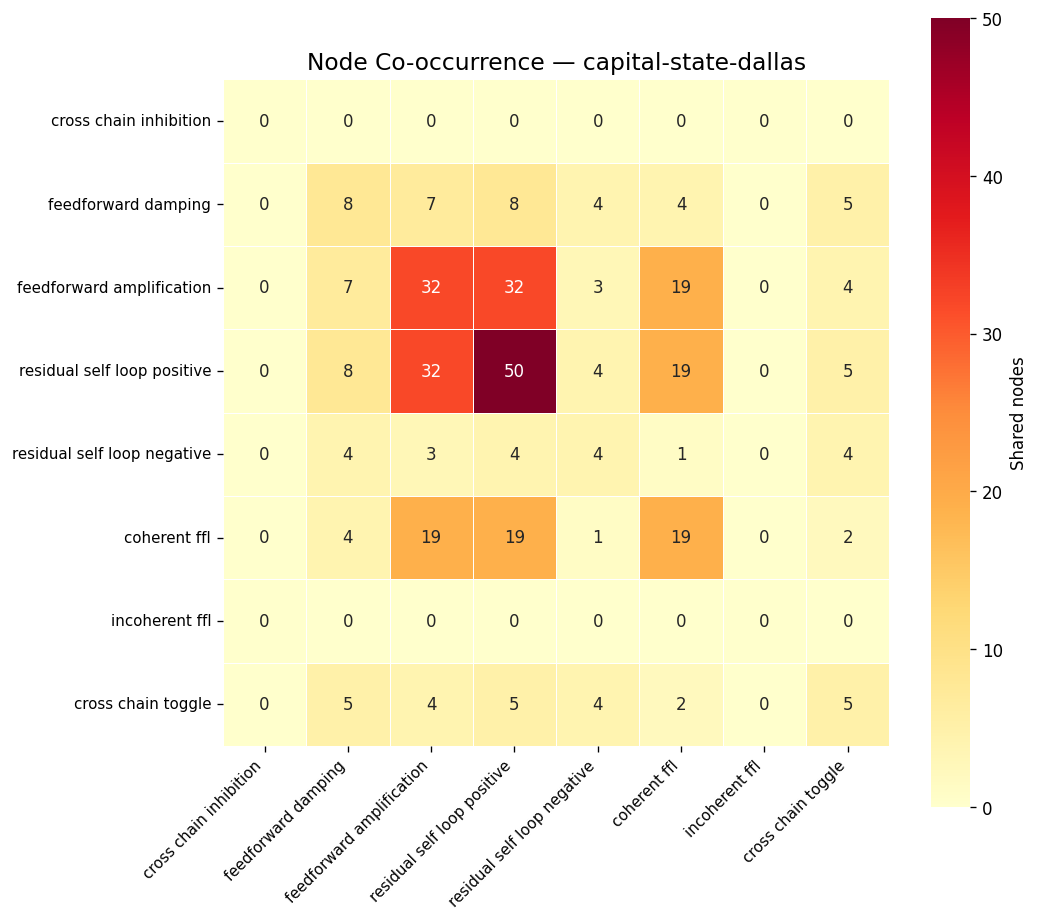

In [ ]:
# Aggregate co-occurrence across all graphs
agg_node_sets: dict[str, set] = defaultdict(set)

for cat in batch_results:
    for r in batch_results[cat]:
        census_r = r['census']
        for name, instances in census_r.items():
            for inst in instances:
                agg_node_sets[name].update(inst.node_indices)

# Single-graph co-occurrence on the Dallas graph for a focused view
fig = plot_cooccurrence_heatmap(
    census,
    title=f"Node Co-occurrence — {dallas_path.stem}",
    figsize=(9, 8),
)
plt.show()

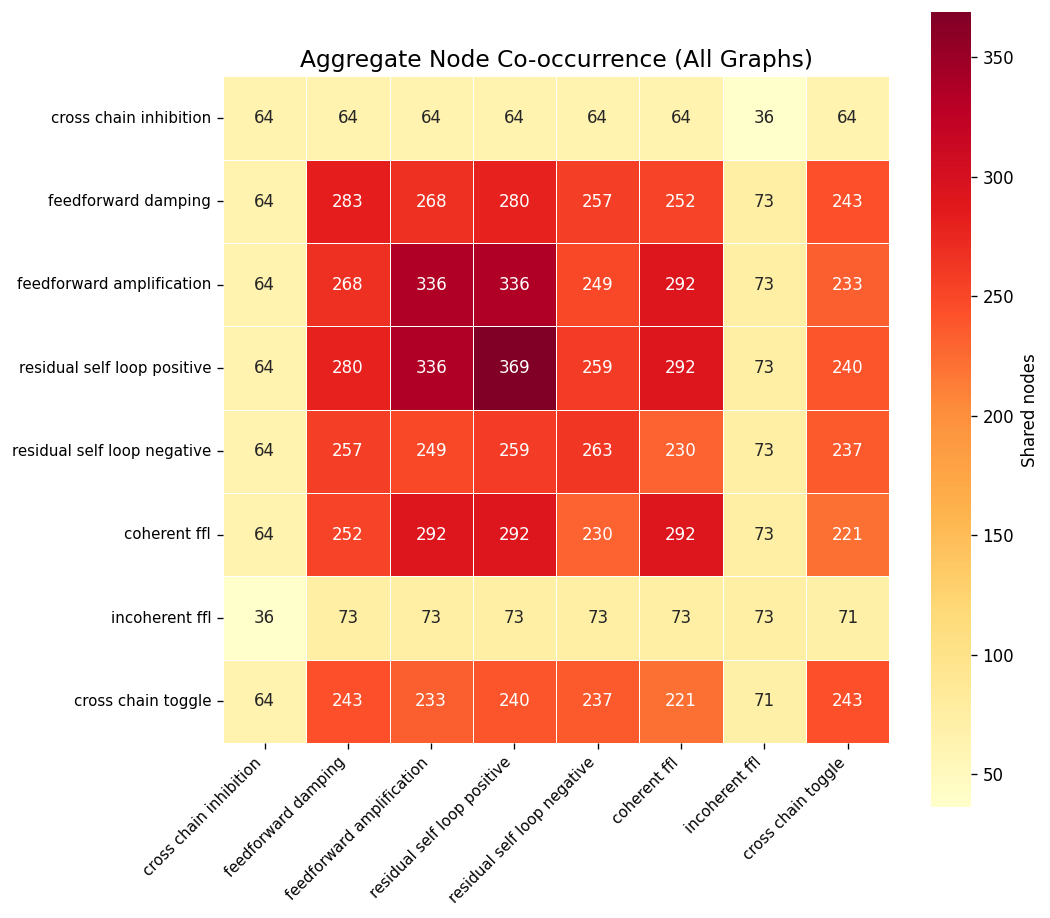

In [ ]:
# Aggregate co-occurrence matrix across all graphs
# For this we merge all census results from the batch
merged_census: dict[str, list] = defaultdict(list)
for cat in batch_results:
    for r in batch_results[cat]:
        for name, instances in r['census'].items():
            merged_census[name].extend(instances)

fig = plot_cooccurrence_heatmap(
    dict(merged_census),
    title="Aggregate Node Co-occurrence (All Graphs)",
    figsize=(9, 8),
)
plt.show()

## 10. Comparison with Standard Triad Census

Compare the unrolled motif results with the standard triad census from
the main pipeline. Do sign-aware unrolled motifs reveal structure that
the topology-only analysis misses?

In [ ]:
# Load standard pipeline results
analysis_path = results_dir / "analysis_summary.json"
if analysis_path.exists():
    with open(analysis_path) as f:
        std_summary = json.load(f)
    print(f"Loaded standard analysis: {len(std_summary['graphs'])} graphs")
    
    # Extract mean Z-scores for standard triads
    from src.motif_census import TRIAD_LABELS, CONNECTED_TRIAD_INDICES
    
    std_zoo = std_summary['motif_zoo']['motif_summary']
    print(f"\nStandard Triad Census (topology only):")
    print(f"{'Motif':<8s}  {'Mean Z':>8s}  {'Enriched':>8s}  {'Depleted':>8s}")
    print("-" * 38)
    for m in std_zoo:
        print(f"{m['label']:<8s}  {m['mean_z']:>+8.2f}  {m['pct_enriched']:>7.1f}%  {m['pct_depleted']:>7.1f}%")
else:
    print("No standard pipeline results found at", analysis_path)
    print("Run: python -m src.pipeline --n-random 100")
    std_summary = None

Loaded standard analysis: 101 graphs

Standard Triad Census (topology only):
Motif       Mean Z  Enriched  Depleted
--------------------------------------
030T        +26.99    100.0%      0.0%
021C        +19.97     97.0%      1.0%
111U        -17.65      0.0%    100.0%
120C        -17.36      0.0%     99.0%
111D        -16.17      0.0%     99.0%
120D        -15.45      0.0%     99.0%
120U        -15.10      0.0%     99.0%
021D        -11.59      5.9%     81.2%
030C        -10.05      0.0%     98.0%
210          -8.97      0.0%     92.1%
201          -7.29      0.0%     94.1%
300          -3.32      0.0%     64.4%
021U         -0.31     33.7%     36.6%
012          +0.00      0.0%      0.0%
102          +0.00      0.0%      0.0%


In [ ]:
# Side-by-side comparison: standard triad FFL (030T) vs unrolled coherent/incoherent FFL
if std_summary is not None:
    # Standard FFL Z-scores per graph
    std_ffl_z = [g['z_scores'].get('030T', 0) for g in std_summary['graphs'] if np.isfinite(g['z_scores'].get('030T', 0))]
    
    # Unrolled FFL SP values (coherent + incoherent) per graph
    unrolled_coherent_sp = []
    unrolled_incoherent_sp = []
    for cat in batch_results:
        for r in batch_results[cat]:
            unrolled_coherent_sp.append(r['sp'].get('coherent_ffl', 0))
            unrolled_incoherent_sp.append(r['sp'].get('incoherent_ffl', 0))
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    axes[0].hist(std_ffl_z, bins=20, color='#6baed6', edgecolor='black', linewidth=0.5)
    axes[0].axvline(x=2, color='red', linestyle='--', alpha=0.5)
    axes[0].set_title('Standard FFL (030T)\nZ-scores (topology only)', fontsize=11, fontweight='bold')
    axes[0].set_xlabel('Z-score')
    axes[0].set_ylabel('Count')
    
    axes[1].hist(unrolled_coherent_sp, bins=20, color='#2ca02c', edgecolor='black', linewidth=0.5)
    axes[1].axvline(x=0, color='black', linewidth=0.5)
    axes[1].set_title('Coherent FFL\nSP (sign-aware)', fontsize=11, fontweight='bold')
    axes[1].set_xlabel('SP value')
    
    axes[2].hist(unrolled_incoherent_sp, bins=20, color='#ff7f0e', edgecolor='black', linewidth=0.5)
    axes[2].axvline(x=0, color='black', linewidth=0.5)
    axes[2].set_title('Incoherent FFL\nSP (sign-aware)', fontsize=11, fontweight='bold')
    axes[2].set_xlabel('SP value')
    
    plt.suptitle('Standard vs Sign-Aware FFL Enrichment', fontsize=13, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"Standard FFL (030T): mean Z = {np.mean(std_ffl_z):+.2f}, "
          f"{sum(1 for z in std_ffl_z if z > 2)/len(std_ffl_z)*100:.0f}% enriched")
    print(f"Coherent FFL:        mean SP = {np.mean(unrolled_coherent_sp):+.3f}")
    print(f"Incoherent FFL:      mean SP = {np.mean(unrolled_incoherent_sp):+.3f}")
    print(f"\nThe standard census lumps coherent and incoherent FFLs together.")
    print(f"SP normalization removes graph-size effects. Splitting by sign")
    print(f"reveals whether enrichment is driven by reinforcing (coherent)")
    print(f"or competing (incoherent) signal paths.")
else:
    print("Skipping comparison — no standard pipeline results available.")

In [ ]:
# Enrichment/depletion summary across all graphs — both Z-score and SP
print(f"Unrolled Motif Enrichment Summary (threshold Z > 2 / Z < -2):")
print(f"{'Motif':<30s}  {'Mean Z':>8s}  {'Mean SP':>8s}  {'Enriched':>8s}  {'Depleted':>8s}  {'Neither':>8s}")
print("-" * 80)

for m in motif_names:
    all_z = []
    all_sp = []
    for cat in batch_results:
        for r in batch_results[cat]:
            all_z.append(r['z_scores'].get(m, 0))
            all_sp.append(r['sp'].get(m, 0))
    
    n = len(all_z)
    if n == 0:
        continue
    mean_z = np.mean(all_z)
    mean_sp = np.mean(all_sp)
    pct_enriched = sum(1 for z in all_z if z > 2) / n * 100
    pct_depleted = sum(1 for z in all_z if z < -2) / n * 100
    pct_neither = 100 - pct_enriched - pct_depleted
    print(f"{m:<30s}  {mean_z:>+8.2f}  {mean_sp:>+8.3f}  {pct_enriched:>7.1f}%  {pct_depleted:>7.1f}%  {pct_neither:>7.1f}%")

## 11. Key Findings & Interpretation

### What the unrolled census reveals

**Sign-aware structure matters.** The standard triad census treats all FFLs as
topologically identical (030T). By splitting into coherent (all-excitatory) and
incoherent (mixed-sign) variants, we can distinguish between:
- **Coherent FFLs**: AND-gate logic, persistent signal detection
- **Incoherent FFLs**: output competition, pulse generation

**Cross-chain inhibition** tests whether competing interpretations (e.g., two
candidate answers in multi-hop reasoning) actively suppress each other across
layers — a feedforward analogue of the biological mutual inhibition motif.

**Feedforward damping** (A→B-|A') tests gain control — whether the network
actively limits how strongly a signal propagates through the residual stream.

### Hypotheses

1. **Safety circuits** should show elevated cross-chain inhibition (refusal
   competes with compliance) and incoherent FFLs (conflicting signals).
2. **Multi-hop reasoning** should show more coherent FFLs and feedforward
   amplification (reinforcing the correct multi-step answer).
3. **Feedforward damping** may be enriched in arithmetic circuits where
   precise gain control matters for carry propagation.

### Next steps

- Increase `n_random` to 500+ for publication-quality Z-scores
- Cross-reference motif instances with clerp labels to identify semantic roles
- Compare unrolled motif profiles across model scales (Gemma 3 family)
- Statistical tests (Kruskal-Wallis) for cross-task differences